# Calculate seasonal trends in rainfall

This will allow for comparing against trends in NDVI seasonality



In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
import contextily as ctx
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from xarrayMannKendall import Mann_Kendall_test

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/climate-carbon-interactions/src')
from _trends import linregress

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology
# from dea_tools.spatial import subpixel_contours

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [2]:
var='rain'
ds_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc'

chunks=None#dict(latitude=1000, longitude=1000, time=-1)

t_range='1982', '2022'

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

# #All of Aus
# lat_bounds = slice(0, 680)
# lon_bounds = slice(0,840)

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path, chunks=chunks)[var], crs='EPSG:4326')
ds = ds.sel(time=slice(t_range[0], t_range[1]))

ds = ds.rename({'latitude':'y', 'longitude':'x'})

### Smoothing filters

In [ ]:
# ds_smooth = ds.resample(time="2W").interpolate("linear")

#rolling mean
# ds_smooth=ds.rolling(time=3, min_periods=1, center=True).mean()

# # # Savitsky-Golay
# ds_smooth = xr.apply_ufunc(
#         scipy.signal.savgol_filter,
#         ds,
#         input_core_dims=[['time']],
#         output_core_dims=[['time']],
#         kwargs=dict(
#             window_length=3,
#             polyorder=2,
#             deriv=0,
#             mode='interp'),
#         dask='allowed'
#     )
# #SG cuts of last 6 months so clip to complete calendar years.
# ds_smooth = ds_smooth.sel(time=slice('1982', '2021'))

In [ ]:
# fig,ax=plt.subplots(1,1, figsize=(12,4))
# ds.mean(['x', 'y']).plot(ax=ax, label='NDVI')
# ds_smooth.mean(['x', 'y']).plot(ax=ax, label='Rainfall Savitsky-Golay')
# # ds_smooth_rolling.mean(['x', 'y']).plot(ax=ax, label='NDVI rolling')
# ax.legend(loc='upper left')
# ax.set_title('Signal smoothing of Rainfall');

### Trends seasonal rainfall



In [4]:
q_rain = ds.resample(time='Q-DEC', label='left').sum()

In [6]:
mask = xr.where(q_rain.mean('time')==0, 0, 1)
q_rain = q_rain.where(mask)

In [7]:
res = {}
for season in ("DJF", "MAM", "JJA", "SON"):
    print(season)
    xx = q_rain.sel(time=q_rain['time.season']==season)
    xx['time'] = xx.time.dt.year
    _trends = Mann_Kendall_test(xx,
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()
    res[season] = _trends


DJF
MAM
JJA
SON


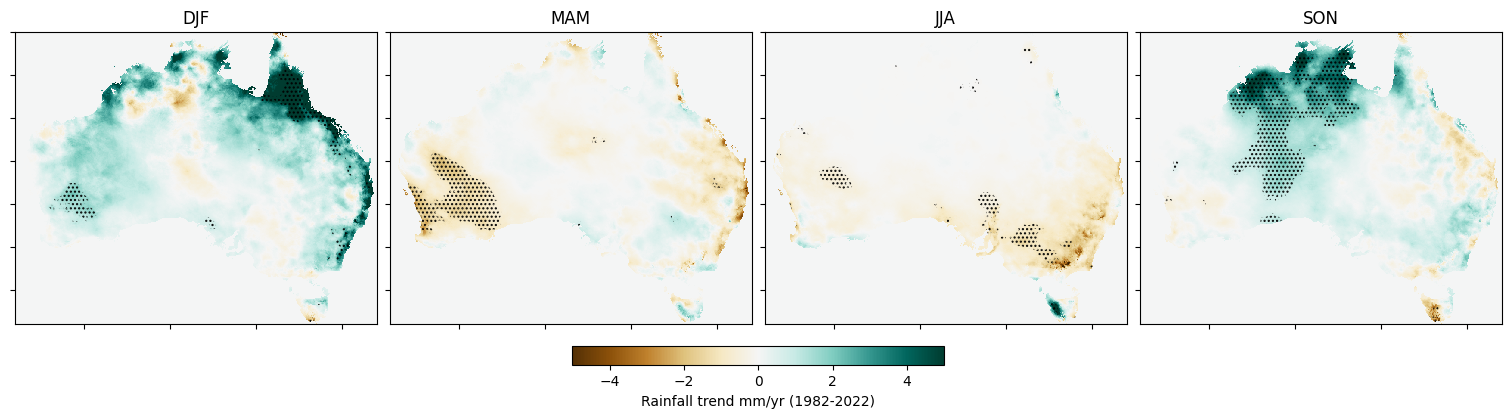

In [8]:
fig,ax = plt.subplots(1,4, figsize=(15,4),sharey=True, layout='constrained')
for s, a in zip(["DJF", "MAM", "JJA", "SON"], ax.reshape(-1)):
    im = res[s].trend.plot(ax=a, cmap='BrBG', vmin=-5, vmax=5, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(res[s].trend.where(res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    a.set_title(s)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.25, orientation='horizontal', label='Rainfall trend mm/yr (1982-2022)')
# plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_"+var+"_per_pixel_trends.png", bbox_inches='tight', dpi=300)

## Rainfall phenology curves

### Per bioregion

In [10]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [11]:
_var = [ds]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(_var, names):
        ds.name=var
        ds_region = v.where(mask)
        
        early_clim = ds_region.sel(time=slice('1982', '2001')).groupby('time.month').mean()
        late_clim = ds_region.sel(time=slice('2002', '2022')).groupby('time.month').mean()
        
        df = early_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df['2002-2022'] = late_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df = df.rename({var:'1982-2001'}, axis=1)
        
        df['region'] = row['region_name']
        # df['Month'] = ["J","F","M","A","M","J","J","A","S","O","N","D"]
        
        inner.append(df)
    outer.append(inner)

dffs=[]
for i in range(0,len(outer)):
    dffs.append(pd.concat(outer[i]))
df_ds_clim = pd.concat(dffs)

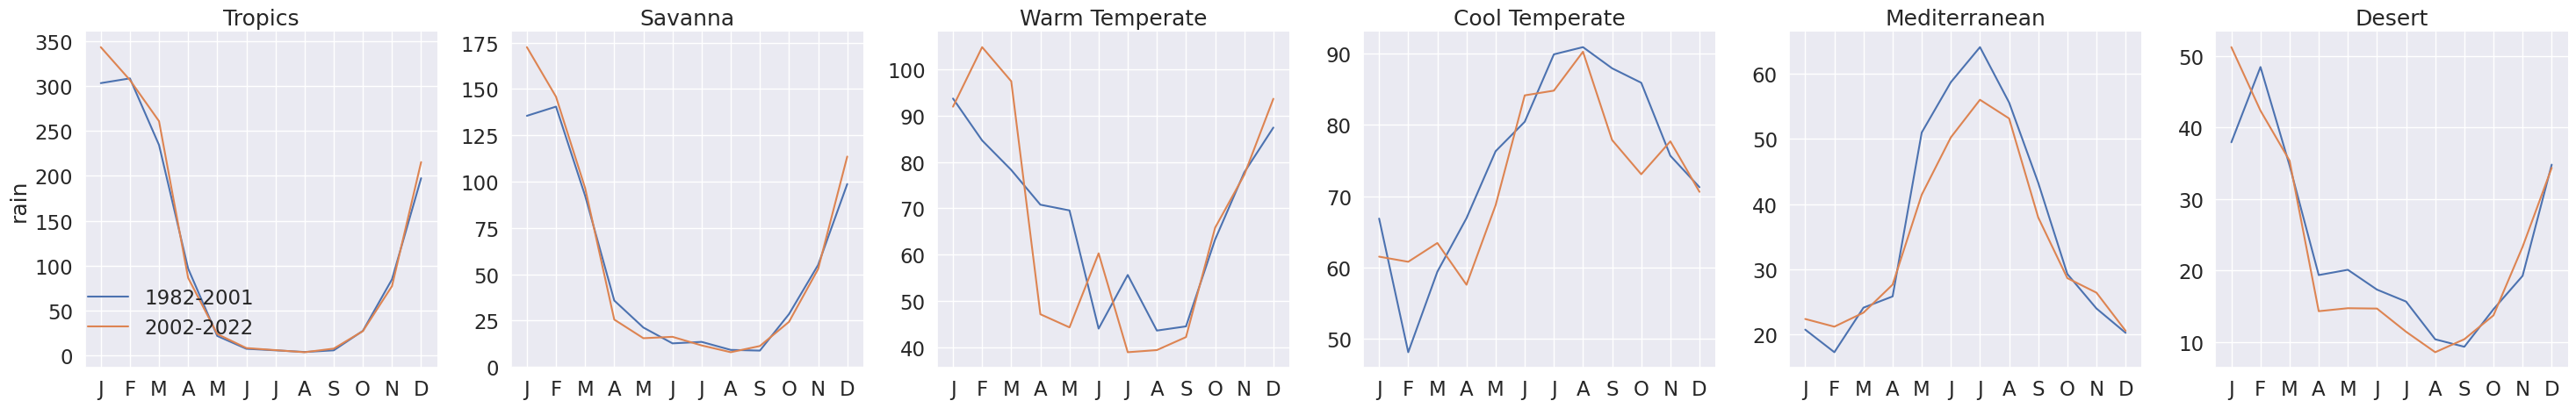

In [12]:
sb.set(font_scale=1.5)
g = sb.relplot(
    data=df_ds_clim.melt(id_vars='region', ignore_index=False, value_name=var, var_name='Climatology Range'),
    x="month",
    y=var,
    col="region",
    hue='Climatology Range',
    col_wrap=6, kind="line", ci=None,
    # palette=sb.color_palette("rocket_r"),
    facet_kws=dict(sharex=True, sharey=False)
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sb.move_legend(g, "upper center", 
    bbox_to_anchor=(.065, 0.35), ncol=1, title=None, frameon=False)
g.set(xlabel=None)
g.set(xticks=range(1,13))
g.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]);
g.tight_layout();
# g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/"+var+"_phenology_bioregion.png",
#           bbox_inches='tight', dpi=300);

### Australian-wide

In [13]:
early_clim = ds.sel(time=slice('1982', '2001')).groupby('time.month').mean()
late_clim = ds.sel(time=slice('2002', '2022')).groupby('time.month').mean()

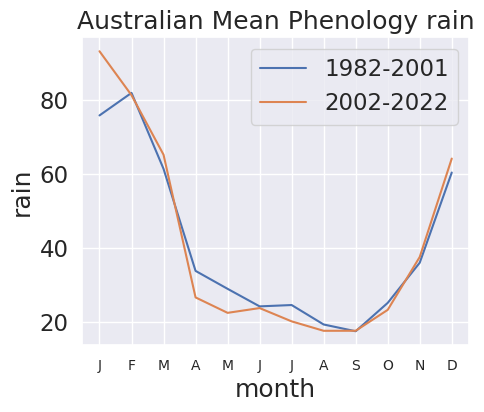

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Australian Mean Phenology '+var)
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);

## Check rainfall changes over specific regions

Focusing on any interesting regions.

In [15]:
#limit regions to tropics ~north of Twownsville
ds_tf = ds.sel(y=slice(0, -19.3))
ds_tf = ds_tf.sel(x=slice(142,147.5))

#tassie
# ds_tf = ds.sel(y=slice(-40, -45), x=slice(144,149))

# mid qld
# ds_tf = ds.sel(y=slice(-20, -25), x=slice(140,150))

#calculate minimum NDVI through the 20 years
tf_min = ds_tf.min('time')

#threshold minimum to get 
tf_mask = tf_min.where(tf_min>0.375)
tf_mask = xr.where(tf_mask>0, 1, 0)

In [16]:
early_clim_tf = ds_tf.where(tf_mask).sel(time=slice('1982', '2000')).groupby('time.month').mean()
late_clim_tf = ds_tf.where(tf_mask).sel(time=slice('2001', '2022')).groupby('time.month').mean()

In [ ]:
# doy['vPOS'].where(tf_mask).mean(['x', 'y']).plot(figsize=(11,4))

In [18]:
# ds.where(tf_mask).mean(['x', 'y']).plot(figsize=(11,4))

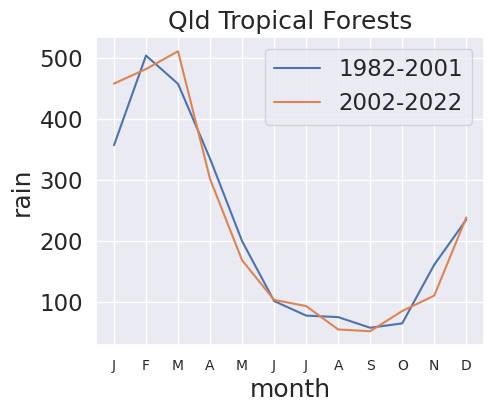

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim_tf.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim_tf.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Qld Tropical Forests')
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);

## Contours

In [ ]:
# # List of elevations to extract
# z_values = [50, 100, 150, 200, 250, 300, 350]

# # Extract contours
# contours_gdf_early = subpixel_contours(da=doy['POS'].sel(year=slice(1982, 2001)).mean('year'), crs='epsg:4326', min_vertices=1000,
#                                  z_values=z_values)

# contours_gdf_late = subpixel_contours(da=doy['POS'].sel(year=slice(2001, 2022)).mean('year'), crs='epsg:4326', min_vertices=1000,
#                                  z_values=z_values)

# fig,ax = plt.subplots(1,1, figsize=(10,10), sharex=True, sharey=True)
# im = contours_gdf_early.plot(ax=ax, linewidth=1.0, cmap='magma', column ='z_value', legend=True, legend_kwds={'shrink': 0.5})
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

# im = contours_gdf_late.plot(ax=ax, linewidth=1.0, cmap='viridis', column ='z_value', legend=True, legend_kwds={'shrink': 0.5})
# # ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

### Rainfall vPOS Phenology

In [ ]:
warnings.simplefilter('ignore')
doy = ds_smooth.groupby('time.year').map(xr_phenology)

Use the Mann-Kendall robust regression (this is quite slow)

In [ ]:
vpos_trends = Mann_Kendall_test(doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()


In [ ]:
fig,ax = plt.subplots(1,2, figsize=(13,6), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,2)):
    if i==0:
        im = doy['vPOS'].median('year').plot(cmap='gist_earth_r',robust=True,
                                   ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        a.set_title('Median vPOS 1982-2022', fontsize=font)
    
    if i==1:
        im = vpos_trends.trend.plot(ax=a, add_labels=False, cmap='BrBG', robust=True, add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical', label='')
        xr.plot.contourf(vpos_trends.trend.where(vpos_trends.signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Trend in vPOS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_"+var+"_per_pixel_trends.png", bbox_inches='tight', dpi=300)